In [39]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import os

# Resistance Calculations From Lyo Cycle Data

### Inputs, Data Loading

In [40]:
#Input Parameters
SAin=5.982843996
SAout=7.0685775
ice_dens=0.918
dens=1.031 #Density for F4 from slides
fill_vol=6.3
water_cont=0.484
dry_cake=(fill_vol*dens)/(SAin*ice_dens)
print("Dry Cake Initial Height:",dry_cake)
lam=0.00358

Dry Cake Initial Height: 1.182629899895259


In [41]:
#Initial Data(SV File)
file_location = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\220715_GS-0132_F4_0C125mT_SV_5MIN.xlsx'
assert os.path.isfile(file_location)
df = pd.read_excel(file_location,sheet_name='220715_GS-0132_F4_0C125mT_SV_5M')
#df = pd.read_excel(file_location)
print(list(df.columns))

#Elapsed Time Array
time=(df[['Timestamp']]).values #every 5 mins
t_m=np.arange(0,len(time)*5,5) #Create array for time passed in increments of 5 mins
print(t_m)

#Pirani Pressure
pirani_pres=(df[[' SPLYO.CHAMBER_PIRANI.F_CV']]).values

#Chamber Pressure
cham_pres=(df[[' SPLYO.CHAMBER_CM.F_CV']]).values

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\sbadih\\OneDrive - Gilead Sciences\\Trodelvy 2.0 Modelling Data\\220715_GS-0132_F4_0C125mT_SV_5MIN.xlsx'

In [ ]:
#Initial Data(PP File)
file_location1 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\220715_GS-0132_F4_0C125mT_PP_5MIN.xlsx'
assert os.path.isfile(file_location1)
df1 = pd.read_excel(file_location1,sheet_name='220715_GS-0132_F4_0C125mT_PP_5M')
print("Headers:")
print(list(df1.columns))

#Find Nested Configuration Temperatures
T_2N=(df1[[' SPLYO.TC06.F_CV']]).values
T_3N=(df1[[' SPLYO.TC03.F_CV']]).values
T_4N=(df1[[' SPLYO.TC01.F_CV']]).values
Tp=(df[[' SPLYO.SHELF_OUTLET.F_CV']]).values ##Check which one this should be?

#Extract Core Thermocouple (TC02)
T_core=(df1[[' SPLYO.TC02.F_CV']]).values

#Print Shape of some variables
print("Shapes:")
print(Tp.shape)
print(t_m.shape)
print(pirani_pres.shape)

In [ ]:
print(cham_pres)

### Sublimation Pressure

In [ ]:
#Function to Calc. Sublimation Pressure
def sub_p(T): #input is temperature
    sp=(np.exp(24.01849-6144.96/((T)+273)))*1000
    return sp

In [ ]:
#Store Sublimation Pressures
sub_pres2=sub_p(T_2N)
sub_pres3=sub_p(T_3N)
sub_pres4=sub_p(T_4N)
sub_pres_core=sub_p(T_core)
print("Sublimation Pressure Shape:",sub_pres2.shape)

##### Index Setup

In [ ]:
#Need to automatically find the index at which we stop calculating any values
    #This is determined by when the Chamber CM reading becomes close to the pirani reading indicating end of primary drying
    
#Start Index
    #This will vary depending on the vial configuration
    #Start index is where the calculated sublimation pressure is equal to the Chamber CM reading(ie where sublimation starts(primary drying))
# 2NN
minimum=[]
ind=[]
for i in range(len(cham_pres)):
    if sub_pres2[i]<98.5:
        ind.append(i)
        minimum.append(cham_pres[i]-sub_pres2[i])
minimum=np.array(minimum) #convert list to array
min_ind2=np.argmin(minimum) #Find the index in the minimum array where the minimum difference occurs
strt_ind2=ind[min_ind2] #Find the index in the sublimation pressure where the minimum occurs

# 3NN
minimum=[]
ind=[]
for i in range(len(cham_pres)):
    if sub_pres3[i]<98.5:
        ind.append(i)
        minimum.append(cham_pres[i]-sub_pres3[i])
minimum=np.array(minimum) #convert list to array
min_ind3=np.argmin(minimum) #Find the index in the minimum array where the minimum difference occurs
strt_ind3=ind[min_ind3] #Find the index in the sublimation pressure where the minimum occurs

# 4NN
minimum=[]
ind=[]
for i in range(len(cham_pres)):
    if sub_pres4[i]<98.5:
        ind.append(i)
        minimum.append(cham_pres[i]-sub_pres4[i])
minimum=np.array(minimum) #convert list to array
min_ind4=np.argmin(minimum) #Find the index in the minimum array where the minimum difference occurs
strt_ind4=ind[min_ind4] #Find the index in the sublimation pressure where the minimum occurs

print("Start Index for 2NN:",strt_ind2)
print("Start Index for 3NN:",strt_ind3)
print("Start Index for 4NN:",strt_ind4)

#Stop Index
index=[]
diff=[]
for i in range(len(pirani_pres[strt_ind2:])): #start where the primary drying starts
    if cham_pres[i+strt_ind2]<200:
        index.append(i+strt_ind2)
        diff.append(pirani_pres[i+strt_ind2]-cham_pres[i+strt_ind2])
diff=np.array(diff)
min_diff=np.argmin(diff) #find index where minimum occurs
   #Stop Index is the same for all vial configurations 
stop_ind=index[min_diff]
print("Stop Index is:",stop_ind) 

Note: The indices here are the points we will set to zero and all values after that is where the calculations start.This applies to Kv calculations up to the resistance calculations on the spreadsheet. 

In [ ]:
#Modify Sub. Pressures based on start indices indicating beginning of sublimation where sub. pres=chamber pres and end indices where pirani converges to chamber pressure
sub_pres2_new=sub_pres2[strt_ind2:stop_ind] 
sub_pres3_new=sub_pres3[strt_ind3:stop_ind]
sub_pres4_new=sub_pres4[strt_ind4:stop_ind]
sub_pres_core_new=sub_pres_core[strt_ind4:stop_ind]
print("New Array Shape for Sub. Pressures:\n")
print("2NN:",sub_pres2_new.shape)
print("3NN:",sub_pres3_new.shape)
print("4NN:",sub_pres4_new.shape)

### Kv Values(Vial Heat Transfer Coefficient)

In [ ]:
#Kv Parameters
a_kv=0.000817654
b_kv=0.00045
c_kv=1.320652597

In [ ]:
#Kv Value Calculations
def Kv_calc(p,factor): #Inputs are pirani pressure reading and adjustment factor
    return a_kv+(b_kv*(p/1000))/ (1+(c_kv*(p/1000))) *factor #might need to adjust the rounding

In [ ]:
# #Assuming Same Kv for all 3 cases for now
# kv_2=Kv_calc(pirani_pres,1)
# kv_3=Kv_calc(pirani_pres,1)
# kv_4=Kv_calc(pirani_pres,1)
# print("Previous Size:",kv_2.shape)
# #Adjust size based on start and stop indices
# kv_2 = kv_2[strt_ind2:]
# kv_3 = kv_3[strt_ind3:]
# kv_4 = kv_4[strt_ind4:]
# print("New Size:",kv_2.shape)

In [ ]:
# Kv Calculations Using the Hyperplane Fitting
value=0.00020961432864185497
# kv_2=np.repeat(7.49795279e-05,len(pirani_pres[strt_ind2:]))
# kv_3=np.repeat(7.49795279e-05,len(pirani_pres[strt_ind3:]))
# kv_4=np.repeat(7.49795279e-05,len(pirani_pres[strt_ind4:]))
kv_2=np.repeat(value,len(pirani_pres[strt_ind2:stop_ind]))
kv_3=np.repeat(value,len(pirani_pres[strt_ind3:stop_ind]))
kv_4=np.repeat(value,len(pirani_pres[strt_ind4:stop_ind]))

In [ ]:
print(kv_2.shape)
print(kv_3.shape)
print(kv_4.shape)

### Heat Flow

In [ ]:
#Heat Flow Calculations
def heat_flow(T,K,index): #inputs are temperature and vial heat transfer coefficient
    hf=np.zeros((K.size))
    for i in range(len(K)):
        hf[i]=abs(Tp[i+index]-T[i+index])*K[i] #Make sure we are sampling the time points correctly
    return hf

In [ ]:
#HF calc. values
hf_2_old=heat_flow(T_2N,kv_2,strt_ind2)
hf_3_old=heat_flow(T_3N,kv_3,strt_ind3)
hf_4_old=heat_flow(T_4N,kv_4,strt_ind4)
hf_core_old=heat_flow(T_core,kv_4,strt_ind4)
#Store indices where hf is zero for later use
ind2_zero=[]
ind3_zero=[]
ind4_zero=[]
indc_zero=[]
for i in range(len(hf_2_old)):
    if hf_2_old[i]==0:
        ind2_zero.append(i)
for i in range(len(hf_3_old)):
    if hf_3_old[i]==0:
        ind3_zero.append(i)

for i in range(len(hf_4_old)):
    if hf_4_old[i]==0:
        ind4_zero.append(i)
for i in range(len(hf_core_old)):
    if hf_core_old[i]==0:
        indc_zero.append(i) 
# #Remove all zero values to prevent infinite resistance calculations
hf_2=np.array([i for i in hf_2_old if i != 0])
hf_3=np.array([i for i in hf_3_old if i != 0])
hf_4=np.array([i for i in hf_4_old if i != 0])
hf_core=np.array([i for i in hf_core_old if i != 0])

print("Size:",hf_2.shape)
print("Size:",hf_3.shape)
print("Size:",hf_4.shape)
print("Size:",hf_core.shape)
#Now no need to use the start/stop indices because everything will depend on previous steps that we already truncated

In [ ]:
#Setting Zero Initial Condition
hf_2[0]=0    
hf_3[0]=0
hf_4[0]=0
hf_core[0]=0

### Sublimation Rate

In [ ]:
#Sub. Rate Calc.
def sub_rate(HF,S): #inputs are heat flow and outer surface area
    sr=HF*(S/676)
    return sr

In [ ]:
#Sublimation Rate Calc. Values
sr_2=sub_rate(hf_2,SAout)
sr_3=sub_rate(hf_3,SAout)
sr_4=sub_rate(hf_4,SAout)
sr_core=sub_rate(hf_core,SAout)
print("Size:",sr_2.shape)
print("Size:",sr_3.shape)
print("Size:",sr_4.shape) #These shapes should match the heatflow shapes
print("Size:",sr_core.shape)

In [ ]:
print(sr_2)

### Mass Sublimed

In [ ]:
#Mass Sublimed Function
    #The index is the spreadsheet row-2
def mass_sub(SR,t,index): #inputs are sublimation rate. time elapsed and start index(indicating beginning of sublimation)
    ms=np.zeros(SR.shape) #initialize array to store mass sublimed 
    for i in range(SR.shape[0]):
        if i==0:
            ms[i]=0
        else:
            ms[i]=ms[i-1]+((SR[i-1]+SR[i])/2)*(t_m[i+index]-t_m[i-1+index])*60 #Making sure to match the time indices
    return ms

In [ ]:
#Mass Sublimed Calc. Values
ms_2=mass_sub(sr_2,t_m,strt_ind2)
ms_3=mass_sub(sr_3,t_m,strt_ind3) 
ms_4=mass_sub(sr_4,t_m,strt_ind4)
ms_core=mass_sub(sr_core,t_m,strt_ind4)

print("Size:",ms_2.shape)
print("Size:",ms_3.shape)
print("Size:",ms_4.shape) #Should match sublimation rate shapes
print(ms_2)

### Dry Layer Height

In [42]:
#Dry Layer Height Function
def dry_h(MS): #Input is mass sublimated
    dlh=MS/(ice_dens*water_cont*SAin) #Since we set ms[0]=0, no need to reset initial conditions here
    return dlh

In [43]:
#Dry Layer Height Calculated
dlh_2=dry_h(ms_2)
dlh_3=dry_h(ms_3)
dlh_4=dry_h(ms_4)
dlh_core=dry_h(ms_core)

print("Size:",dlh_2.shape)
print("Size:",dlh_3.shape)
print("Size:",dlh_4.shape) #Again sizes should match up
print("Final Dry Layer Height Predicted By Model:",dlh_2[dlh_2.shape[0]-1])

Size: (544,)
Size: (544,)
Size: (543,)
Final Dry Layer Height Predicted By Model: 0.8991090044579073


Note: Model predicts the dry layer height well as this value is close to what was measured experimentally as the dry layer height.

### Sublimation Temperature

In [44]:
# Sublimation Temperature Function
def sub_temp(T,HF,DLH,strt_index,index,stop_index): #inputs are temperature,heat flow,dry layer height,start index and the zeros HF index
    f=((HF*(dry_cake-DLH))/lam)
    T=T[strt_index:stop_index]
    T=np.delete(T, index)
    T=T.reshape(f.size) #Get rid of the extra second dimension
    st=T-f
    return st

In [45]:
# Sublimation Temperature Calculations
st_2=sub_temp(T_2N,hf_2,dlh_2,strt_ind2,ind2_zero,stop_ind)
st_3=sub_temp(T_3N,hf_3,dlh_3,strt_ind3,ind3_zero,stop_ind)
st_4=sub_temp(T_4N,hf_4,dlh_4,strt_ind4,ind4_zero,stop_ind)
st_core=sub_temp(T_core,hf_core,dlh_core,strt_ind4,indc_zero,stop_ind)
print("Size:",st_2.shape)
print("Size:",st_3.shape)
print("Size:",st_4.shape) #Again shapes should match

Size: (544,)
Size: (544,)
Size: (543,)


In [46]:
#Set Initial Condtions
st_2[0]=0   
st_3[0]=0
st_4[0]=0
st_core[0]=0

### Measured Resistance(Experimental)

In [47]:
#Measured Resistance Function
def res_calc(SP,CM,SR,strt_ind,index,stop_index): #Inputs are sublimation pressure, chamber pressure,sublimation rate and start index
    SP=SP.reshape(SP.shape[0]) #Get rid of extra dimension
    CM=CM.reshape(CM.shape[0])
    SP=SP[strt_ind:stop_index]
    CM=CM[strt_ind:stop_index] #Make sure we're extracting the correct pressures
    SP=np.delete(SP, index)
    CM=np.delete(CM, index)
    r_m=(SP-CM)*(SAin/(SR*3600))
    r_m[0]=0 #Set initial condition
    return r_m

In [48]:
#Measured Resistance Calculations
rm_2=res_calc(sub_pres2,cham_pres,sr_2,strt_ind2,ind2_zero,stop_ind)
rm_3=res_calc(sub_pres3,cham_pres,sr_3,strt_ind3,ind3_zero,stop_ind)
rm_4=res_calc(sub_pres4,cham_pres,sr_4,strt_ind4,ind4_zero,stop_ind)
rm_core=res_calc(sub_pres_core,cham_pres,sr_core,strt_ind4,indc_zero,stop_ind)

print("Size:",rm_2.shape)
print("Size:",rm_3.shape)
print("Size:",rm_4.shape) #Again shapes should match

Size: (544,)
Size: (544,)
Size: (543,)


<ipython-input-47-4b3398be3b6b>:9: RuntimeWarning: divide by zero encountered in true_divide
  r_m=(SP-CM)*(SAin/(SR*3600))


Text(0, 0.5, 'Resistance[(mT*hr*cm2/g)]')

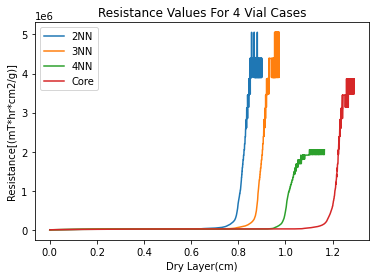

In [49]:
#Visualize Measured Resistance Values
plt.plot(dlh_2,rm_2,label="2NN")
plt.plot(dlh_3,rm_3,label="3NN")
plt.plot(dlh_4,rm_4,label="4NN")
plt.plot(dlh_core,rm_core,label="Core")
plt.title("Resistance Values For 4 Vial Cases")
plt.legend()
plt.xlabel("Dry Layer(cm)")
plt.ylabel("Resistance[(mT*hr*cm2/g)]")

Text(0.5, 1.0, 'Resistance Values For 4 Vial Cases')

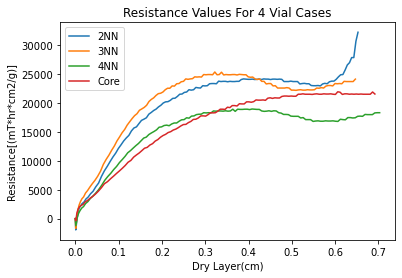

In [55]:
plt.plot(dlh_2[0:125],rm_2[0:125],label="2NN")
plt.plot(dlh_3[0:125],rm_3[0:125],label="3NN")
plt.plot(dlh_4[0:125],rm_4[0:125],label="4NN")
plt.plot(dlh_core[0:125],rm_core[0:125],label="Core")
plt.legend()
plt.xlabel("Dry Layer(cm)")
plt.ylabel("Resistance[(mT*hr*cm2/g)]")
plt.title("Resistance Values For 4 Vial Cases")

### OLS for Resistance 

In [51]:
R_calc=np.array([rm_2,rm_3,rm_4,rm_core],dtype="object")
d=np.array([dlh_2,dlh_3,dlh_4,dlh_core],dtype="object")
print(R_calc[1].shape)
print(len(R_calc))
ic2=np.array([0,52500,2])
ic3=np.array([0,93000,3.5])
ic4=np.array([0,120100,5.9])
ic_c=np.array([0,120100,5.9])
ic=np.array([ic2,ic3,ic4,ic_c])
print(ic)

(544,)
4
[[0.000e+00 5.250e+04 2.000e+00]
 [0.000e+00 9.300e+04 3.500e+00]
 [0.000e+00 1.201e+05 5.900e+00]
 [0.000e+00 1.201e+05 5.900e+00]]


In [52]:
print("Time I fitted to(hrs):",t_m[125]/60)

Time I fitted to(hrs): 10.416666666666666


0
Current Vial Case: 2NN
Parameters for 2NN : [2.37967969e-04 1.50500000e+05 3.92977818e+00]
1
Current Vial Case: 3NN
Parameters for 3NN : [2.11020015e+02 1.50001112e+05 4.23697031e+00]
2
Current Vial Case: 4NN
Parameters for 4NN : [2.30943948e-03 1.20100000e+05 4.58371880e+00]
3
Current Vial Case: core
Parameters for core : [1.42191708e-03 1.20100000e+05 3.65804215e+00]


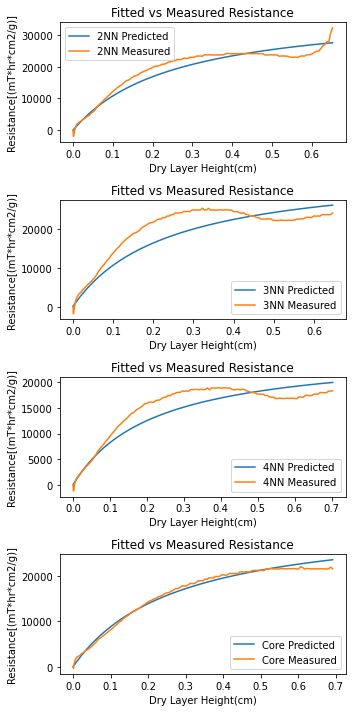

In [53]:
#Least Squares Fitting of Resistance Values

#Define matrices to hold Calculated Resistance Values,Dry Layer Height(measured), and initial condition estimates
R_calc_all=np.array([rm_2,rm_3,rm_4,rm_core],dtype="object")
d_all=np.array([dlh_2,dlh_3,dlh_4,dlh_core],dtype="object")
ic2=np.array([0,150500,2])
ic3=np.array([0,150000,500])
ic4=np.array([0,120100,5.9])
ic_c=np.array([0,120100,5.9])
#ic4=np.array([0,60000,450])
ic=np.array([ic2,ic3,ic4,ic_c])
#x=np.array([rm_2.shape[0],rm_3.shape[0],rm_4.shape[0]]) #I tried this first to see if fitting until end of primary drying would be better
x=np.array([125,125,125,125]) #ending up fitting up to the 125th time step ()
model=["2NN","3NN","4NN","core"]
plt.figure(figsize=(5, 10))
for i in range(len(R_calc_all)): #loop over vial cases
    print(i)
    print("Current Vial Case:",model[i])
    R_calc=(R_calc_all[i][0:x[i]]).astype("float") #Select appropriate R and d values for this run, and truncate 
    d=(d_all[i][0:x[i]]).astype("float")
    #Define Residuals Function
    def residuals(theta,d,R_calc):
        R_fit = theta[0]+((theta[1]*d)/(1+theta[2]*d)) #Calculated Resistance
        res=R_fit-R_calc      
        return res

    #Define Parameter Set
        #theta=[a,b,c]
    theta_0=(ic[i]).astype("float") #Set initial Condition

    #Least Squares Fitting
    param=least_squares(residuals,theta_0, loss='soft_l1', f_scale=0.1,args=(d,R_calc))
    print("Parameters for",model[i],":",param.x)
    
    #Find predicted resistance values
    R_pred=param.x[0]+((param.x[1]*d)/(1+param.x[2]*d)) 

    #Plotting
    labels_p=["2NN Predicted","3NN Predicted","4NN Predicted","Core Predicted"]
    labels_m=["2NN Measured","3NN Measured","4NN Measured","Core Measured"]
    plt.subplot(4, 1, i+1)
    plt.plot(d,R_pred,label=labels_p[i])
    plt.plot(d,R_calc,label=labels_m[i])
    plt.xlabel("Dry Layer Height(cm)")
    plt.ylabel("Resistance[(mT*hr*cm2/g)]")
    plt.title("Fitted vs Measured Resistance")
    plt.legend()
    plt.tight_layout()

### Another Package for higher order fitting
https://lmfit.github.io/lmfit-py/

Might try this? Dont know what our acceptance criteria is. 

https://stackoverflow.com/questions/51972637/nonlinear-regression-with-python-whats-a-simple-method-to-fit-this-data-bette   

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

# Extra Stuff

[1.05010025e+02 6.00023663e+04 1.48194889e+00]


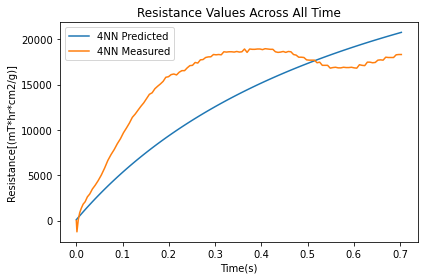

In [54]:
#Least Squares Fitting of Resistance Values

#Define matrices to hold Calculated Resistance Values and Dry Layer Height
R_calc=rm_4[0:125]
d=dlh_4[0:125]

#Define Residuals Function
def residuals(theta,d,R_calc):
    R_fit = theta[0]+((theta[1]*d)/(1+theta[2]*d)) #Calculated Resistance
    res=R_fit-R_calc
    return res

#Define Parameter Set
    #theta=[a,b,c]

#theta_0=[0,120100,5.9] #Random guess for initial conditions #Model Changes as we change initial conditions
theta_0=[0,60000,450]

#Least Squares Fitting
res1=least_squares(residuals,theta_0, loss='soft_l1', f_scale=0.1,args=(d,R_calc))
print(res1.x)

#Plotting
R_pred=res1.x[0]+((res1.x[1]*d)/(1+res1.x[2]*d)) 
plt.plot(dlh_4[0:125],R_pred,label="4NN Predicted")
plt.plot(dlh_4[0:125],rm_4[0:125],label="4NN Measured")
plt.xlabel("Time(s)")
plt.ylabel("Resistance[(mT*hr*cm2/g)]")
plt.title("Resistance Values Across All Time")
plt.legend()
plt.tight_layout()